# MalikAdan: OpenLab Drilling Project

## Purpose

Use OpenLab to automatically tag bottom and then drill 5 meters. 

## Methodology

Using the Python API for OpenLab, the program will drill up to a bit depth of around 2506 m. After the simulation, the following graphs are created:

- flow in and flow out
- hookspeed and rop
- bit depth and hole depth
- surface rpm and torque

## Resources
- Tutorial to help connect to OpenLab using Python: https://openlab.app/tutorial/new-install-and-authenticate-python/
- tutorial to implement a WOB autodriller using Python: https://openlab.app/tutorial/wob-auto-driller/

# Library Import

**Step 1**: Connect to OpenLab

In [2]:
!pip install openlab
import matplotlib.pyplot as plt
import openlab  # Importing the openlab library

     -------------------------------------- 151.7/151.7 kB 9.4 MB/s eta 0:00:00


DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 52.2/52.2 kB 2.6 MB/s eta 0:00:00
  Created wheel for uuid: filename=uuid-1.30-py3-none-any.whl size=6501 sha256=2c7cd6c234d3076e0afb7601313ac3ecc6fdd4b85212000d533321ef09c5c7dc
  Stored in directory: c:\users\st35345\appdata\local\pip\cache\wheels\05\d7\b4\4795d29c6decfffbf64c63e58b6c8b8bbfd4751488617dcd7a
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7048 sha256=b7d5ca99395368406dbb64c8578d39a494f6779ded4663debde84a905d7656b9
  Stored in directory: c:\users\st35345\appdata\local\pip\cache\wheels\04\bb\0d\2d02ec45f29c48d6192476bfb59c5a0e64b605e7212374dd15
Successfully built uuid littleutils


In [32]:
# copy and paste the code for your login below
username="email@gmail.com"
apikey="*************************************************"
licenseguid="*********-****-****-****-*************"

session = openlab.http_client(username=username, apikey=apikey, licenseguid=licenseguid)

00:23:39 [INFO] Initializing Openlab http client
00:23:39 [INFO] Creating token
00:23:40 [INFO] Saving token
00:23:41 [INFO] Login Succesfull


**Step 2**: Create a Simulation

In [35]:
# update the code below to reflect the name of your configuration
config_name = "Config_name_drilling"
sim_name = "Name_of_Simulation"
initial_bit_depth = 2506

sim = session.create_simulation(config_name, sim_name, initial_bit_depth)

00:24:05 [INFO] User limits: {'ActiveSimulationCount': 0, 'MaxConcurrentSimulations': 1, 'MaxSimulationCount': 50, 'MaxStepCount': 1800, 'MaxStoredSimulations': 2, 'MaxTimeStep': 900, 'TotalSimulationCount': 18, 'UsedCapacityPercent': 16, 'UsedStepCount': 283}
00:24:05 [INFO] No influx mode selected. Defaulting to 'NoInfluxLoss'
00:24:21 [INFO] Simulation Initialized


**Start the Simulation and turn the pumps on**

Note, OpenLab still has the bug where setpoint changes are not reflected immediately in the simulation.

In [97]:
#We define the lists here
list_of_flow_in, list_of_flow_out, list_hookspeed, list_rate_of_penetration, list_depth_of_bit, list_DHole, list_rpm_at_surface, list_torque, list_time = ([] for _ in range(9))

sim.step(2)
sim.setpoints.FlowRateIn = 3000/60000
sim.setpoints.SurfaceRPM= 100/60
sim.setpoints.TopOfStringVelocity = 0.5
sim.setpoints.DesiredROP = 0.02

list_loop = [10, 100, 200, 220]
for i in list_loop:
    sim.step(i)

sim.setpoints.FlowRateIn = 0
sim.setpoints.DesiredROP = 0
sim.setpoints.SurfaceRPM= 0
sim.step(220)
sim.setpoints.TopOfStringVelocity = -0.075
sim.step(221)
sim.step(222)
sim.step(280)

for time in range(1, 300):
    results = sim.get_results(time, ['BitDepth', 'TD', 'FlowRateIn', 'FlowRateOut', 
                                     'TopOfStringVelocity', 'InstantaneousROP', 
                                     'SurfaceRPM', 'SurfaceTorque'])

    rop = results['InstantaneousROP'][time]
    rpm_at_surface_2 = results['SurfaceRPM'][time]
    DHole = results['TD'][time]
    torque = results['SurfaceTorque'][time]
    hookspeed = results['TopOfStringVelocity'][time]
    DBit = results['BitDepth'][time]    
    flow_in = results['FlowRateIn'][time]
    flow_out = results['FlowRateOut'][time]

    data_pairs = [
    (list_depth_of_bit, DBit),
    (list_DHole, DHole),
    (list_of_flow_in, flow_in),
    (list_of_flow_out, flow_out),
    (list_hookspeed, hookspeed),
    (list_rate_of_penetration, rop),
    (list_rpm_at_surface, rpm_at_surface_2),
    (list_time, time),
    (list_torque, torque)]

    for list_ref, value in data_pairs:
        list_ref.append(value)

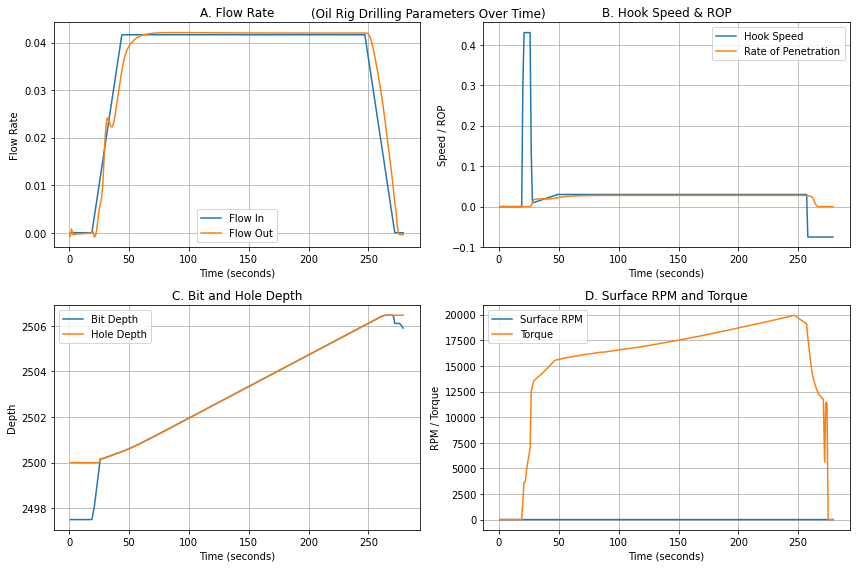

In [102]:
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.plot(list_time, list_of_flow_in, label='Flow In')
plt.plot(list_time, list_of_flow_out, label='Flow Out')
plt.xlabel('Time (seconds)')
plt.ylabel('Flow Rate')
plt.title('A. Flow Rate')
plt.legend()
plt.grid(True)

plt.subplot(222)
plt.plot(list_time, list_hookspeed, label='Hook Speed')
plt.plot(list_time, list_rate_of_penetration, label='Rate of Penetration')
plt.xlabel('Time (seconds)')
plt.ylabel('Speed / ROP')
plt.title('B. Hook Speed & ROP')
plt.legend()
plt.grid(True)

plt.subplot(223)
plt.plot(list_time, list_depth_of_bit, label='Bit Depth')
plt.plot(list_time, list_DHole, label='Hole Depth')
plt.xlabel('Time (seconds)')
plt.ylabel('Depth')
plt.title('C. Bit and Hole Depth')
plt.legend()
plt.grid(True)

plt.subplot(224)
plt.plot(list_time, list_rpm_at_surface, label='Surface RPM')
plt.plot(list_time, list_torque, label='Torque')
plt.xlabel('Time (seconds)')
plt.ylabel('RPM / Torque')
plt.title('D. Surface RPM and Torque')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.suptitle('(Oil Rig Drilling Parameters Over Time)')
plt.show()

In [ ]:
sim.stop()